# Lung cancer CXR classification
- Fastai
- vit
- Resolution: 512x512

In [3]:
from fastai.vision.all import *
from PIL import Image, ImageOps
from fastai.vision.widgets import *

In [4]:
!nvidia-smi

Tue Aug 15 09:39:59 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      On | 00000000:3D:00.0 Off |                  N/A |
| 31%   30C    P8               25W / 250W|   6924MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
torch.cuda.set_device(2)

In [6]:
stats = ([0.56, 0.56, 0.56],[0.27, 0.27, 0.27])
#imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [7]:
def HImageBlock():  # For DataBlock
    return TransformBlock(type_tfms=PILImage.create, item_tfms=[Resize(384)],
                          batch_tfms=[IntToFloatTensor, *aug_transforms(do_flip=False, size=384), Normalize.from_stats(*stats)])

In [8]:
dblock = DataBlock(blocks=(HImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(valid_name='val'),
                   get_y=parent_label)

In [9]:
training = Path('/data/home/xmonzonis/lung_CXR/LungX_V1/')

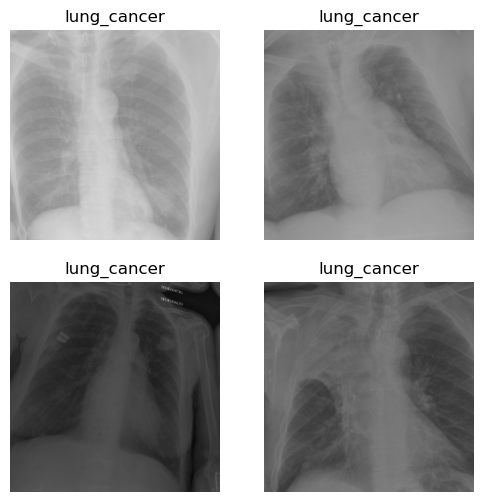

In [11]:
dls = dblock.dataloaders(training, bs=8, num_workers=4)
dls.show_batch(max_n=4)

In [12]:
dls.valid.vocab

['lung_cancer', 'no_cancer']

In [13]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.0494, 0.0494, 0.0494], device='cuda:2'),
 TensorImage([0.9838, 0.9838, 0.9838], device='cuda:2'))

## Training

In [14]:
import timm
entrypoints = timm.list_models(pretrained=True)
for e in entrypoints:
    if "vit" in e:
        print(e)

convit_base.fb_in1k
convit_small.fb_in1k
convit_tiny.fb_in1k
crossvit_9_240.in1k
crossvit_9_dagger_240.in1k
crossvit_15_240.in1k
crossvit_15_dagger_240.in1k
crossvit_15_dagger_408.in1k
crossvit_18_240.in1k
crossvit_18_dagger_240.in1k
crossvit_18_dagger_408.in1k
crossvit_base_240.in1k
crossvit_small_240.in1k
crossvit_tiny_240.in1k
davit_base.msft_in1k
davit_small.msft_in1k
davit_tiny.msft_in1k
flexivit_base.300ep_in1k
flexivit_base.300ep_in21k
flexivit_base.600ep_in1k
flexivit_base.1000ep_in21k
flexivit_base.1200ep_in1k
flexivit_base.patch16_in21k
flexivit_base.patch30_in21k
flexivit_large.300ep_in1k
flexivit_large.600ep_in1k
flexivit_large.1200ep_in1k
flexivit_small.300ep_in1k
flexivit_small.600ep_in1k
flexivit_small.1200ep_in1k
gcvit_base.in1k
gcvit_small.in1k
gcvit_tiny.in1k
gcvit_xtiny.in1k
gcvit_xxtiny.in1k
levit_128.fb_dist_in1k
levit_128s.fb_dist_in1k
levit_192.fb_dist_in1k
levit_256.fb_dist_in1k
levit_384.fb_dist_in1k
levit_conv_128.fb_dist_in1k
levit_conv_128s.fb_dist_in1k
levi

In [16]:
learn = vision_learner(dls, 'vit_large_patch16_384.augreg_in21k_ft_in1k', metrics=[accuracy, RocAucBinary()], pretrained=True).to_fp16()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.490492,0.188607,0.923203,0.978252,02:59
1,0.401507,0.169685,0.928105,0.982770,03:04
2,0.395289,0.255541,0.897059,0.969298,02:57
3,0.355886,0.139696,0.950980,0.988893,02:58
4,0.283873,0.245369,0.887255,0.979711,02:53
5,0.294063,0.126660,0.944444,0.989728,02:53
6,0.312080,0.204130,0.901961,0.974727,02:55
7,0.280973,0.142594,0.933007,0.987342,02:57
8,0.286278,0.139654,0.947712,0.988253,02:56
9,0.254369,0.161484,0.933007,0.986040,02:55


Better model found at epoch 0 with roc_auc_score value: 0.9782519090593543.


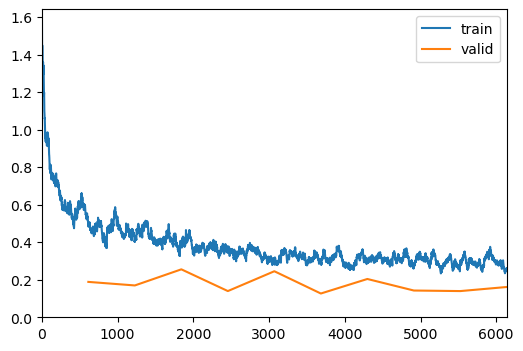

Better model found at epoch 1 with roc_auc_score value: 0.9827696546338076.
Better model found at epoch 3 with roc_auc_score value: 0.9888927455744534.
Better model found at epoch 5 with roc_auc_score value: 0.9897279590419993.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.246266,0.131921,0.944444,0.991225,04:03
1,0.220674,0.199560,0.915033,0.984624,04:03
2,0.189085,0.221708,0.915033,0.983198,04:03
3,0.217058,0.289135,0.883987,0.978865,04:01
4,0.242492,0.140688,0.934641,0.993373,04:01
5,0.205395,0.124937,0.947712,0.990563,04:01
6,0.211235,0.133592,0.946078,0.991914,04:00
7,0.179828,0.100414,0.959150,0.994685,04:02
8,0.177960,0.128187,0.950980,0.990899,04:02
9,0.159123,0.174466,0.928105,0.991615,04:01


Better model found at epoch 0 with roc_auc_score value: 0.9912248351266921.


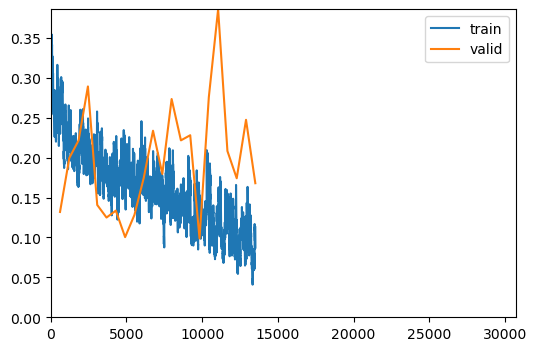

Better model found at epoch 4 with roc_auc_score value: 0.9933725269003818.
Better model found at epoch 7 with roc_auc_score value: 0.9946850052065255.
No improvement since epoch 7: early stopping


In [17]:
learn.fine_tune(50, freeze_epochs=10,
                cbs=[EarlyStoppingCallback(monitor='roc_auc_score', patience=15),
                     ShowGraphCallback(),
                     SaveModelCallback(monitor='roc_auc_score', with_opt=True, 
                                       fname='fastai2_LungCancer_v1_vitL16')])

## Test

In [18]:
learn = learn.load('fastai2_LungCancer_v1_vitL16')

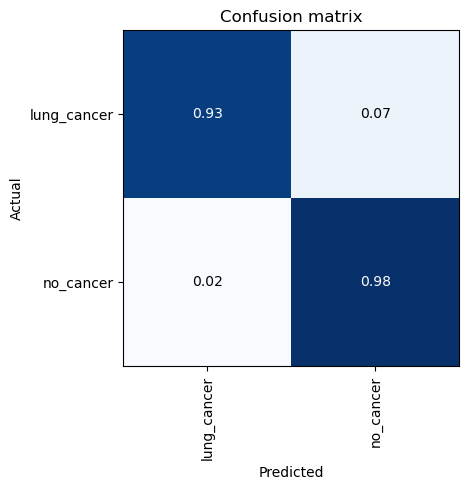

In [19]:
test_set = Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test')
images_test = get_image_files(test_set)
learn.dls.loaders.append(dls.test_dl(list(images_test), with_labels=True))
interp = ClassificationInterpretation.from_learner(learn, ds_idx=2)
interp.plot_confusion_matrix(normalize=True)

In [20]:
interp.print_classification_report()

              precision    recall  f1-score   support

 lung_cancer       0.98      0.93      0.95       268
   no_cancer       0.95      0.98      0.97       364

    accuracy                           0.96       632
   macro avg       0.96      0.96      0.96       632
weighted avg       0.96      0.96      0.96       632



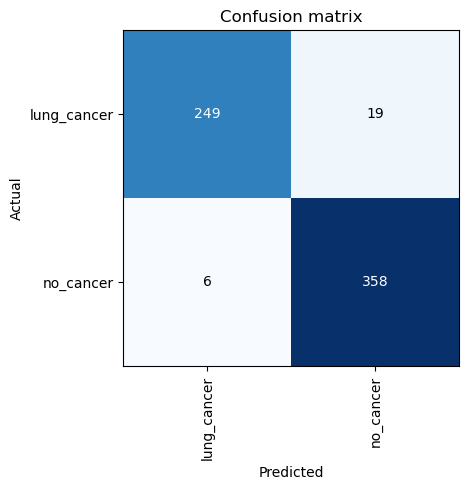

In [21]:
interp.plot_confusion_matrix(normalize=False)

In [22]:
from sklearn.metrics import roc_auc_score

# Load the test dataset
test_set = Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test')
images_test = get_image_files(test_set)
test_dl = dls.test_dl(list(images_test), with_labels=True)

# Get the predictions and true labels for the test dataset
preds, targets = learn.get_preds(dl=test_dl)

# Compute the AUC score
auc_score = roc_auc_score(targets, preds[:, 1])  # Assuming binary classification, use preds[:, 1] for positive class predictions

print("AUC score:", auc_score)

AUC score: 0.9958176152206003


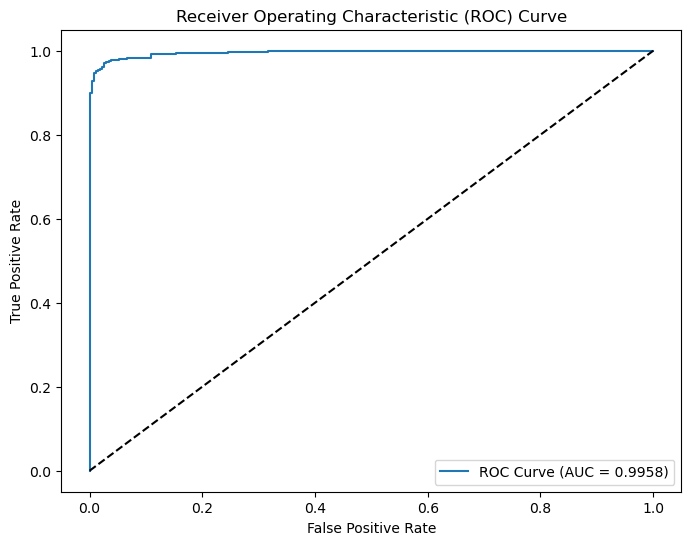

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(targets, preds[:, 1])  # Assuming binary classification, use preds[:, 1] for positive class predictions

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.4f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import precision_recall_curve, auc

# Load the test dataset
test_set = Path('/data/home/xmonzonis/lung_CXR/LungX_V1/test')
images_test = get_image_files(test_set)
test_dl = dls.test_dl(list(images_test), with_labels=True)

# Get the predictions and true labels for the test dataset
preds, targets = learn.get_preds(dl=test_dl)

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(targets, preds[:, 1])  # Assuming binary classification, use preds[:, 1] for positive class predictions

# Compute PR AUC
pr_auc = auc(recall, precision)

print("Precision-Recall AUC:", pr_auc)

Precision-Recall AUC: 0.9971712834311381


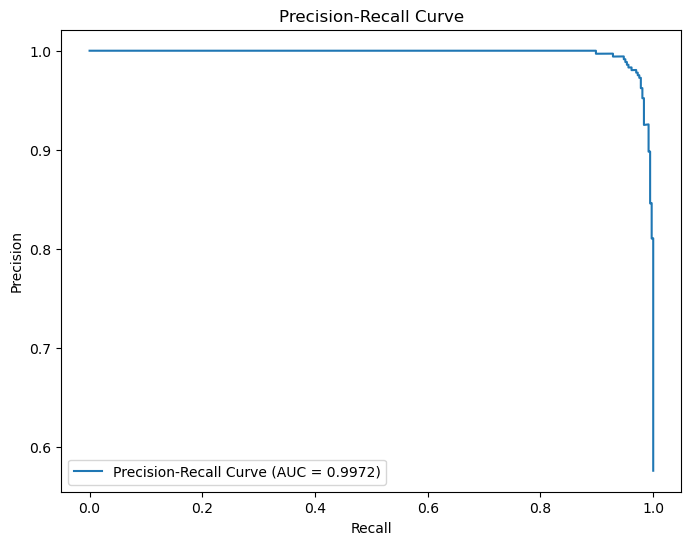

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(targets, preds[:, 1])  # Assuming binary classification, use preds[:, 1] for positive class predictions

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve (AUC = {:.4f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

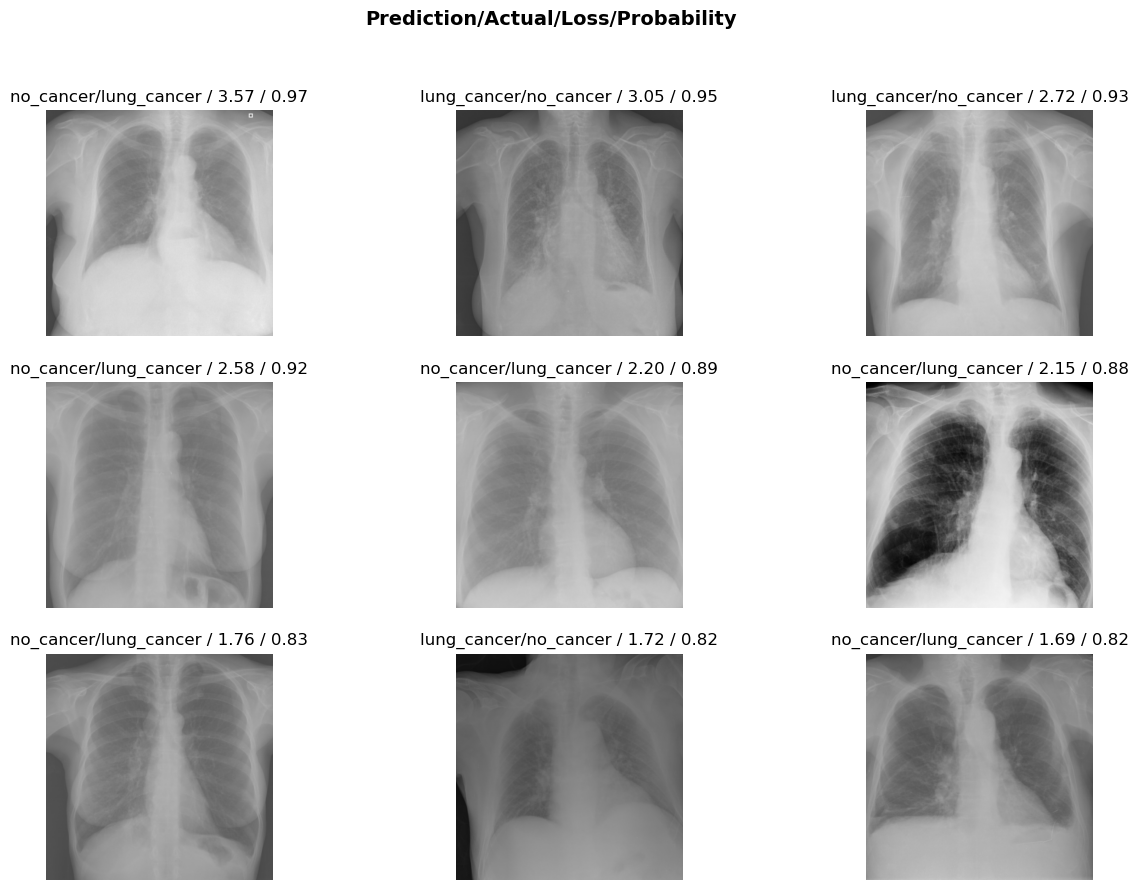

In [26]:
interp.plot_top_losses(9, figsize=(15,10))